In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

/Users/xxyy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
df = pd.read_csv("/Users/xxyy/Documents/InfoUma_24:25/Text Analytics/dati/lab_lem_merged.csv", skipinitialspace=True)
df

,id,title,artist,year,views,features,is_country,is_pop,is_rap,is_rb,is_rock,stanza_number,is_chorus,lemmatized_stanzas,label
0,0,Something in the Water,Pokey LaFarge,2015,10902,{''},True,False,False,False,False,0,False,"['she', 'get', 'a', 'broke', 'down', 'el', 'ca...",anger
1,0,Something in the Water,Pokey LaFarge,2015,10902,{''},True,False,False,False,False,1,True,"['something', 'in', 'the', 'water', 'something...",anger
2,0,Something in the Water,Pokey LaFarge,2015,10902,{''},True,False,False,False,False,2,False,"['she', 'do', 'her', 'makeup', 'and', 'hair', ...",anticipation
3,0,Something in the Water,Pokey LaFarge,2015,10902,{''},True,False,False,False,False,4,False,"['my', 'hoosi', 'girl', 'be', 'so', 'fine', 's...",fear
4,0,Something in the Water,Pokey LaFarge,2015,10902,{''},True,False,False,False,False,5,True,"['something', 'in', 'the', 'water', 'something...",fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57955,11010,Lay It in My Hand,The Real Group,2009,71,{''},False,True,False,False,False,6,False,"['come', 'and', 'release', 'your', 'confidence...",trust
57956,11011,Stop Calling,Lina Morgana,2008,74,{''},False,True,False,False,False,0,False,"['when', 'the', 'sun', 'kill', 'the', 'moon', ...",trust
57957,11011,Stop Calling,Lina Morgana,2008,74,{''},False,True,False,False,False,1,False,"['and', 'I', 'do', 'not', 'care', 'anymore', '...",fear
57958,11011,Stop Calling,Lina Morgana,2008,74,{''},False,True,False,False,False,2,True,"['stop', 'call', 'I', 'have', 'stop', 'care', ...",fear


In [6]:
X = df['lemmatized_stanzas']
y = df['label']

# Trasformazione in rappresentazione TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

In [7]:
# Divisione iniziale del dataset in train e test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Cross-Validation con StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Random Forest

In [12]:
clf = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features='sqrt',
                             random_state=0,
                             n_jobs=-1)

In [14]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))

print(classification_report(y_test, y_pred))

Accuracy 0.3270358868184955
F1-score [0.43214787 0.15703971 0.13715711 0.34630593 0.26322581 0.23946995
 0.1862955  0.25421734]
              precision    recall  f1-score   support

       anger       0.31      0.72      0.43      2555
anticipation       0.49      0.09      0.16       932
     disgust       0.44      0.08      0.14       677
        fear       0.30      0.40      0.35      2071
         joy       0.36      0.21      0.26      1470
     sadness       0.40      0.17      0.24      1486
    surprise       0.50      0.11      0.19       760
       trust       0.36      0.20      0.25      1641

    accuracy                           0.33     11592
   macro avg       0.40      0.25      0.25     11592
weighted avg       0.37      0.33      0.29     11592



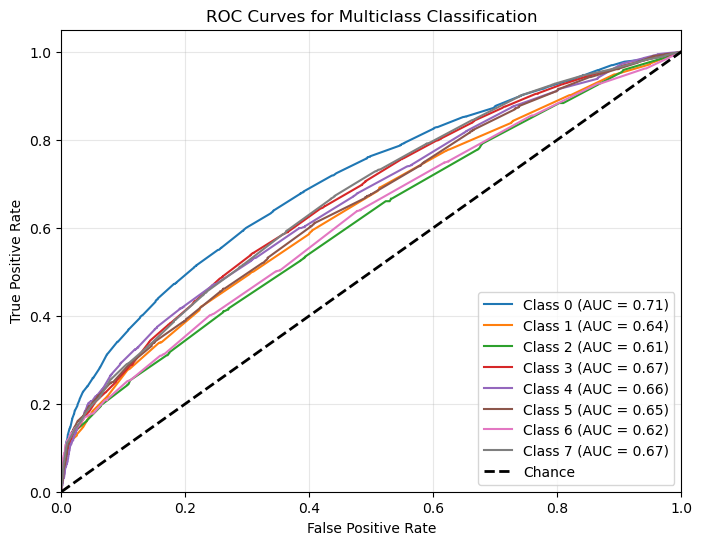

In [24]:
# Binarize the labels for ROC computation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Get decision scores (or probabilities if clf supports predict_proba)
try:
    y_score = clf.decision_function(X_test)
except AttributeError:
    y_score = clf.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
clf = RandomForestClassifier()

param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
              'max_features' : ["sqrt", "log2", None],
              'criterion' : ["gini", "entropy"],
              'class_weight' : ["balanced", None, "balanced_subsample"]
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=20, cv=cv, verbose=0, error_score=0)
random_search.fit(X_train, y_train)

In [ ]:
print(random_search.best_score_, random_search.best_params_)

n_estimators=550, min_samples_split=10, min_samples_leaf=11, max_features=None, max_depth=60, criterion='gini', bootstrap=True

Uso i parametri migliori trovati con Random Search per Random Forest

In [8]:
clf = RandomForestClassifier(n_estimators=550, min_samples_split=10, min_samples_leaf=11,
                              max_features=None, max_depth=60, criterion='gini', bootstrap=True)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))

print(classification_report(y_test, y_pred))

Accuracy 0.28467908902691513
F1-score [0.40737041 0.04162331 0.01464129 0.32550398 0.16853933 0.14158305
 0.00784314 0.20584603]
              precision    recall  f1-score   support

       anger       0.28      0.72      0.41      2555
anticipation       0.69      0.02      0.04       932
     disgust       0.83      0.01      0.01       677
        fear       0.26      0.42      0.33      2071
         joy       0.27      0.12      0.17      1470
     sadness       0.41      0.09      0.14      1486
    surprise       0.60      0.00      0.01       760
       trust       0.32      0.15      0.21      1641

    accuracy                           0.28     11592
   macro avg       0.46      0.19      0.16     11592
weighted avg       0.39      0.28      0.22     11592



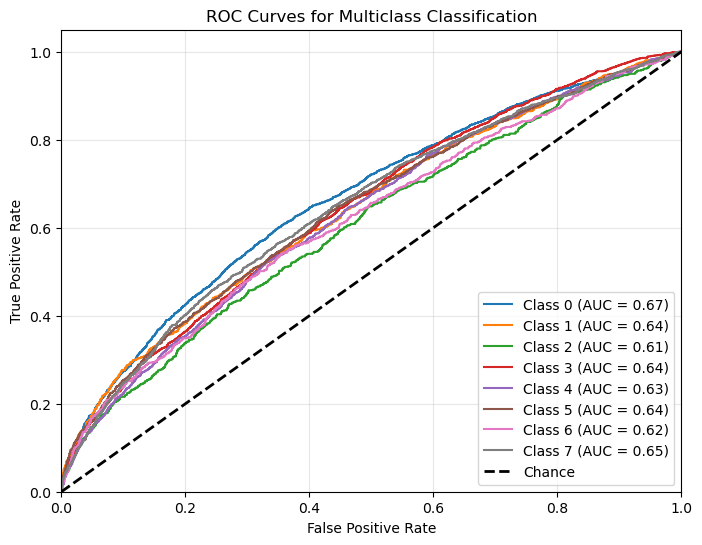

In [9]:
# Binarize the labels for ROC computation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Get decision scores (or probabilities if clf supports predict_proba)
try:
    y_score = clf.decision_function(X_test)
except AttributeError:
    y_score = clf.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## SVM

 **LinearSVC** also implements an alternative multi-class strategy, the so-called multi-class SVM formulated by Crammer and Singer [16], by using the option multi_class='crammer_singer'. In practice, one-vs-rest classification is usually preferred, since the results are mostly similar, but the runtime is significantly less.

Questi sono i parametri migliori trovai con Random Search per SVM

In [27]:
clf = LinearSVC(C=0.9, tol=0.1, max_iter=5000, class_weight=None, random_state=42)
ovo_clf = OneVsOneClassifier(clf) # One-vs-One Classifier

ovo_clf.fit(X_train, y_train)

y_pred = ovo_clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.2976190476190476
F1-score [0.4306535  0.13031161 0.06823529 0.34354805 0.21672291 0.24991274
 0.10631896 0.2681182 ]
              precision    recall  f1-score   support

       anger       0.36      0.54      0.43      2555
anticipation       0.19      0.10      0.13       932
     disgust       0.17      0.04      0.07       677
        fear       0.30      0.40      0.34      2071
         joy       0.24      0.20      0.22      1470
     sadness       0.26      0.24      0.25      1486
    surprise       0.22      0.07      0.11       760
       trust       0.27      0.26      0.27      1641

    accuracy                           0.30     11592
   macro avg       0.25      0.23      0.23     11592
weighted avg       0.28      0.30      0.28     11592



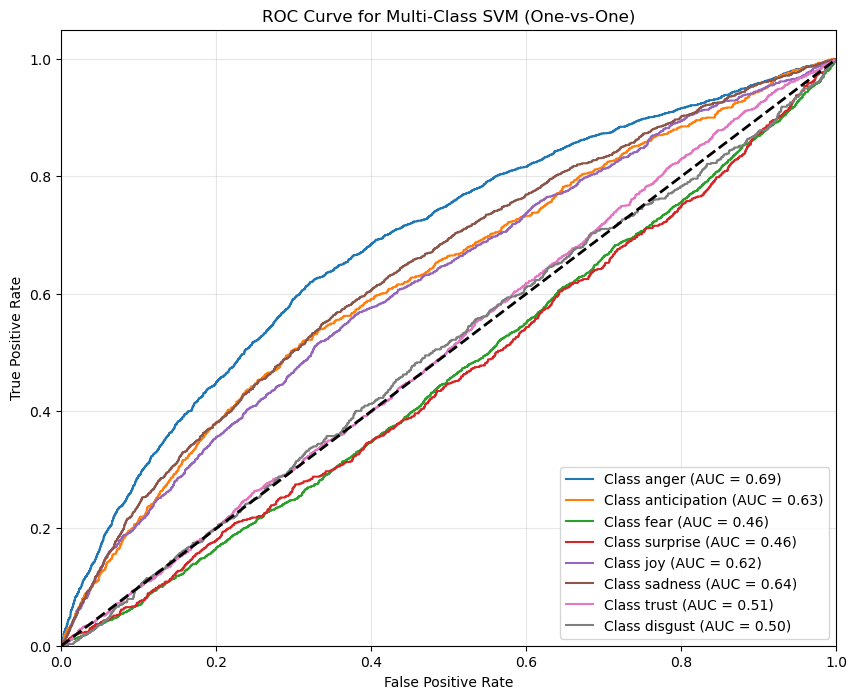

In [29]:
# Binarizzazione delle etichette per il supporto multi-classe
classes = y.unique()
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Calcolo delle probabilità del modello
# (Nota: LinearSVC non fornisce probabilità, ma possiamo usare la decision_function)
y_score = ovo_clf.decision_function(X_test)

# Plot delle ROC curve per ogni classe
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

# Aggiungi la linea di riferimento (y=x)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configura il grafico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class SVM (One-vs-One)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [10]:
clf = LinearSVC(C=0.9, tol=0.1, max_iter=5000, class_weight=None, random_state=42)
# senza nulla, dovrebbe fare ovr

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

/Users/xxyy/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy 0.2996894409937888
F1-score [0.4324826  0.12931034 0.08018868 0.34260977 0.22019742 0.24818578
 0.12121212 0.26562986]
              precision    recall  f1-score   support

       anger       0.36      0.55      0.43      2555
anticipation       0.20      0.10      0.13       932
     disgust       0.20      0.05      0.08       677
        fear       0.30      0.40      0.34      2071
         joy       0.25      0.20      0.22      1470
     sadness       0.27      0.23      0.25      1486
    surprise       0.24      0.08      0.12       760
       trust       0.27      0.26      0.27      1641

    accuracy                           0.30     11592
   macro avg       0.26      0.23      0.23     11592
weighted avg       0.28      0.30      0.28     11592



In [11]:
clf = LinearSVC(C=0.9, tol=0.1, max_iter=5000, class_weight=None, random_state=42)
ovr_clf = OneVsRestClassifier(clf) # One-vs-One Classifier
# con ovr wrapper

ovr_clf.fit(X_train, y_train)

y_pred = ovr_clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

/Users/xxyy/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/xxyy/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/xxyy/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/xxyy/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/xxyy/anaconda3/lib/py

Accuracy 0.3006383712905452
F1-score [0.43501    0.13390313 0.07934656 0.34342187 0.21675634 0.25009088
 0.12192724 0.26353678]
              precision    recall  f1-score   support

       anger       0.36      0.55      0.44      2555
anticipation       0.20      0.10      0.13       932
     disgust       0.19      0.05      0.08       677
        fear       0.30      0.40      0.34      2071
         joy       0.25      0.19      0.22      1470
     sadness       0.27      0.23      0.25      1486
    surprise       0.24      0.08      0.12       760
       trust       0.27      0.26      0.26      1641

    accuracy                           0.30     11592
   macro avg       0.26      0.23      0.23     11592
weighted avg       0.28      0.30      0.28     11592



## Conclusioni

Al momento, il support diverso per le vari classi non aiuta nella classificazione, bisogna fare Under Sampling per bilanciare il support dei classificatori

Poi, per migliorare la performance dei modelli per le classi non ben riconosciute, quando invece dovrebbero esserlo come tristezza, Con TF-idf prendere le top 5/10 parole più rappresentative di una classe non ben riconosciuta, e aggiungere per ogni parola una feature binaria 01 che segnala la presenza/assenza di quella parola nella stanza, così si aiuta il classificato. Attenzione a non aggiungere troppe parole o si fa overfitting.